# Image Classification

We show in this tutorial how to use DRAGON for image classification task. We need to create a search space with two graphs, one treating 2D data, and a second one treating 1D data.

## Loading the dataset

/home/b98181/miniconda3/envs/autogluon/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


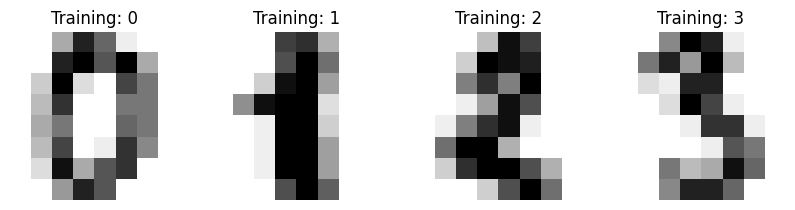

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)


In [3]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    digits.images, digits.target, test_size=0.5, shuffle=False
)

## Defining the Loss function

#### DNN definition

In [4]:
import torch.nn as nn
from dragon.search_space.bricks.pooling import MaxPooling2D
from dragon.search_space.bricks.basics import MLP
from dragon.search_space.cells import AdjCell, CandidateOperation

class ClassificationDNN(nn.Module):
    def __init__(self, args, config) -> None:
        super().__init__()
        self.input_shape = config['ImageShape']
        self.cell_2d = AdjCell(args[0], input_shape=self.input_shape)
        input_channels = self.cell_2d.output_shape[1]
        self.linked = CandidateOperation("add", MaxPooling2D(args[1]), input_channels)
        print(self.cell_2d.output_shape)
        linked_shape = self.cell_2d.output_shape // args[1]
        self.cell_1d = AdjCell(args[2], input_shape=linked_shape)
        self.output = CandidateOperation("add", MLP(in_channels=self.cell_1d.output_shape, out_channels=1), input_channels=self.cell_1d.output_shape)

    def forward(self, x):
        out_2d = self.cell_2d(x)
        pooled = self.linked(out_2d)
        flat = nn.Flatten()(pooled)
        out_1d = self.cell_1d(flat)
        out = self.output(out_1d)
        return out